# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

EPS = 1.0e-7

In [2]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.0, 2.0], cov=[[1.0, 0.5], [0.5, 1.0]])
mv2 = multivariate_normal(mean=[-3.0, -3.0], cov=[[1.0, 0.0], [0.0, 1.0]])


def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))

    return np.asarray(p_x).reshape(len(x1), len(x2))

In [4]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10.0, 10.0, 400)
x2 = np.linspace(-10.0, 10.0, 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

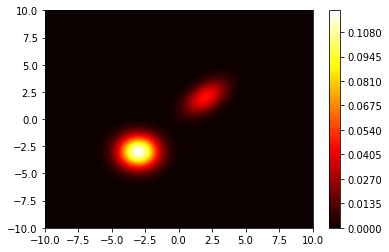

In [5]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap="hot")
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**
We have two modes, one at (2,2) and one at (-3,-3). The most probable point is (-3,-3).

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**
is the gaussian distribution with mean $\mathbf{x}_{old}$ and covariance as the same as the original distribution.

**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**
1. irreducibility: this means that there is a positive probability of visiting all states (Lec 3 slides). 
2. aperiodicity: this means that the chain should not get trapped in cycles (Lec 3 slides). this is true for our proposal distribution because we sample from a gaussian distribution randomly.

In [72]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# =========
# Implement the Metropolis Hastings (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then.


class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.1):
        self.prob = prob
        self.std = std
        self.x_old = x

    def proposal(self, x):
        # PLEASE FILL IN
        # apply the proposal distribution
        x_new = np.random.normal(x, self.std)
        return x_new

    def evaluate(self, x_new, x_old):
        # PLEASE FILL IN
        # evaluate the acceptance
        # EPS is added in case of a zero devision
        # A(x', x_t) = min(1, (p(x')* q(x_t|x')/(p(x_t)* q(x'|x_t))))
        # define q(x1 | x2)
        def q(x_1, x_2):
            # q(x1 | x2) = N(x1 | x2)
            mv = multivariate_normal(np.squeeze(x_2))
            return mv.pdf(x_1)
        A =(self.prob(x_new) * q(x_old, x_new)) / (self.prob(x_old) * q(x_new, x_old) + EPS)
        # return the acceptance
        return np.minimum(1.0, A)

    def select(self, x_new, A):
        # PLEASE FILL IN
        # ...
        # NOTE: If a new candidate is not selected, we must return self.x_old
        # select the new candidate if A > random number u ~ U(0,1)
        if np.random.uniform() < A:
            # update the old candidate
            self.x_old = x_new
        # return the old candidate either updated or the prev one
        return self.x_old


    def step(self):
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

In [73]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x / p_x.sum(), 100, cmap="hot")

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0  # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x), 0)

    ax.scatter(x_samp[:, 0], x_samp[:, 1], marker="+")
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + " AR={:.2f}".format(count / num_epochs))

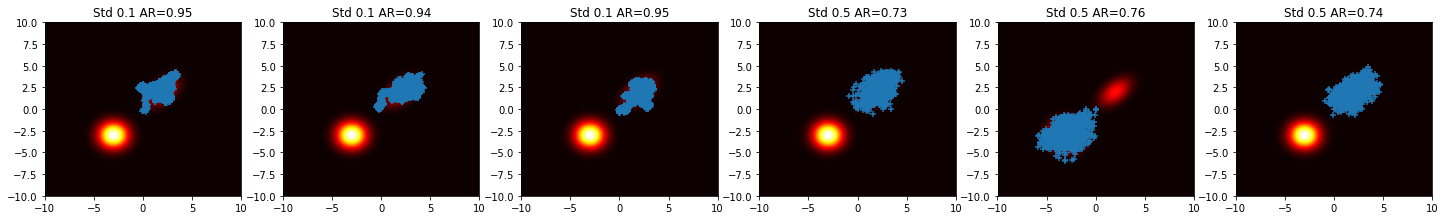

In [75]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5]  # we repeat experiments 3 times per std
## If you add any other hyperparameters, please include them during init!
## However, please do not include them in the for-loop. It should stay for stds only.

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1, len(stds), figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0.0, 0.0]])

for i in range(len(stds)):
    # take the std
    std = stds[i]
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=prob, std=std)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title="Std " + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes theoretically? What did you observe in practice on plots? 

**Answer**: PLEASE FILL IN

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: PLEASE FILL IN

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: PLEASE FILL IN

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: PLEASE FILL IN

In [95]:
# =========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
# =========
# Implement the Simulated Annealing (SA) algorithm.
# It is equivalent to implementing the step function.
class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1.0, C=1.0):
        self.prob = prob
        self.std = std
        self.x_old = x
        self.T0 = T0
        self.C = C
        self.t = 0  # we init the step number to 0; we need it for cooling scheme

    def proposal(self, x):
        # PLEASE FILL IN
        # apply the proposal distribution
        x_new = np.random.normal(x, self.std)
        return x_new

    def evaluate(self, x_new, x_old, T):
        # PLEASE FILL IN
        # evaluate the acceptance
        # EPS is added for the chance of a zero devision 
        # A(x', x_t) = min(1, (p(x')^(1/T1)* q(x_t|x')/(p(x_t)^(1/T1)* q(x'|x_t))))
        def q(x_1, x_2):
            mv = multivariate_normal(np.squeeze(x_2))
            return mv.pdf(x_1)
        A =  ((self.prob(x_new)**(1/T)) * q(x_old, x_new))  / ((self.prob(x_old)**(1/T)) * q(x_new, x_old))
        return np.minimum(1.0, A)
  
    def select(self, x_new, A):
        # PLEASE FILL IN
        # select the new candidate if A > random number u ~ U(0,1)
        if np.random.uniform() < A:
            # update the old candidate
            self.x_old = x_new
        # return the old candidate
        return self.x_old


    def step(self):
        # The temperature scheme (the cooling scheme)
        # PLEASE FILL IN
        # temperature update based on chosen cooling schedule
        # based on the schedule given in the lecture
        # T = C * ln(t + T0) ^ -1
        # EPS is added to avoid division by zero as in the previous parts
        T = self.C * (np.log(self.t + self.T0) + EPS) ** -1
        self.t += 1
        # 1. Proposal
        x_prop = self.proposal(self.x_old)
        # 2. Evaluate
        A = self.evaluate(x_prop, self.x_old, T)
        # 3. Select
        x_new = self.select(x_prop, A)
        return x_new

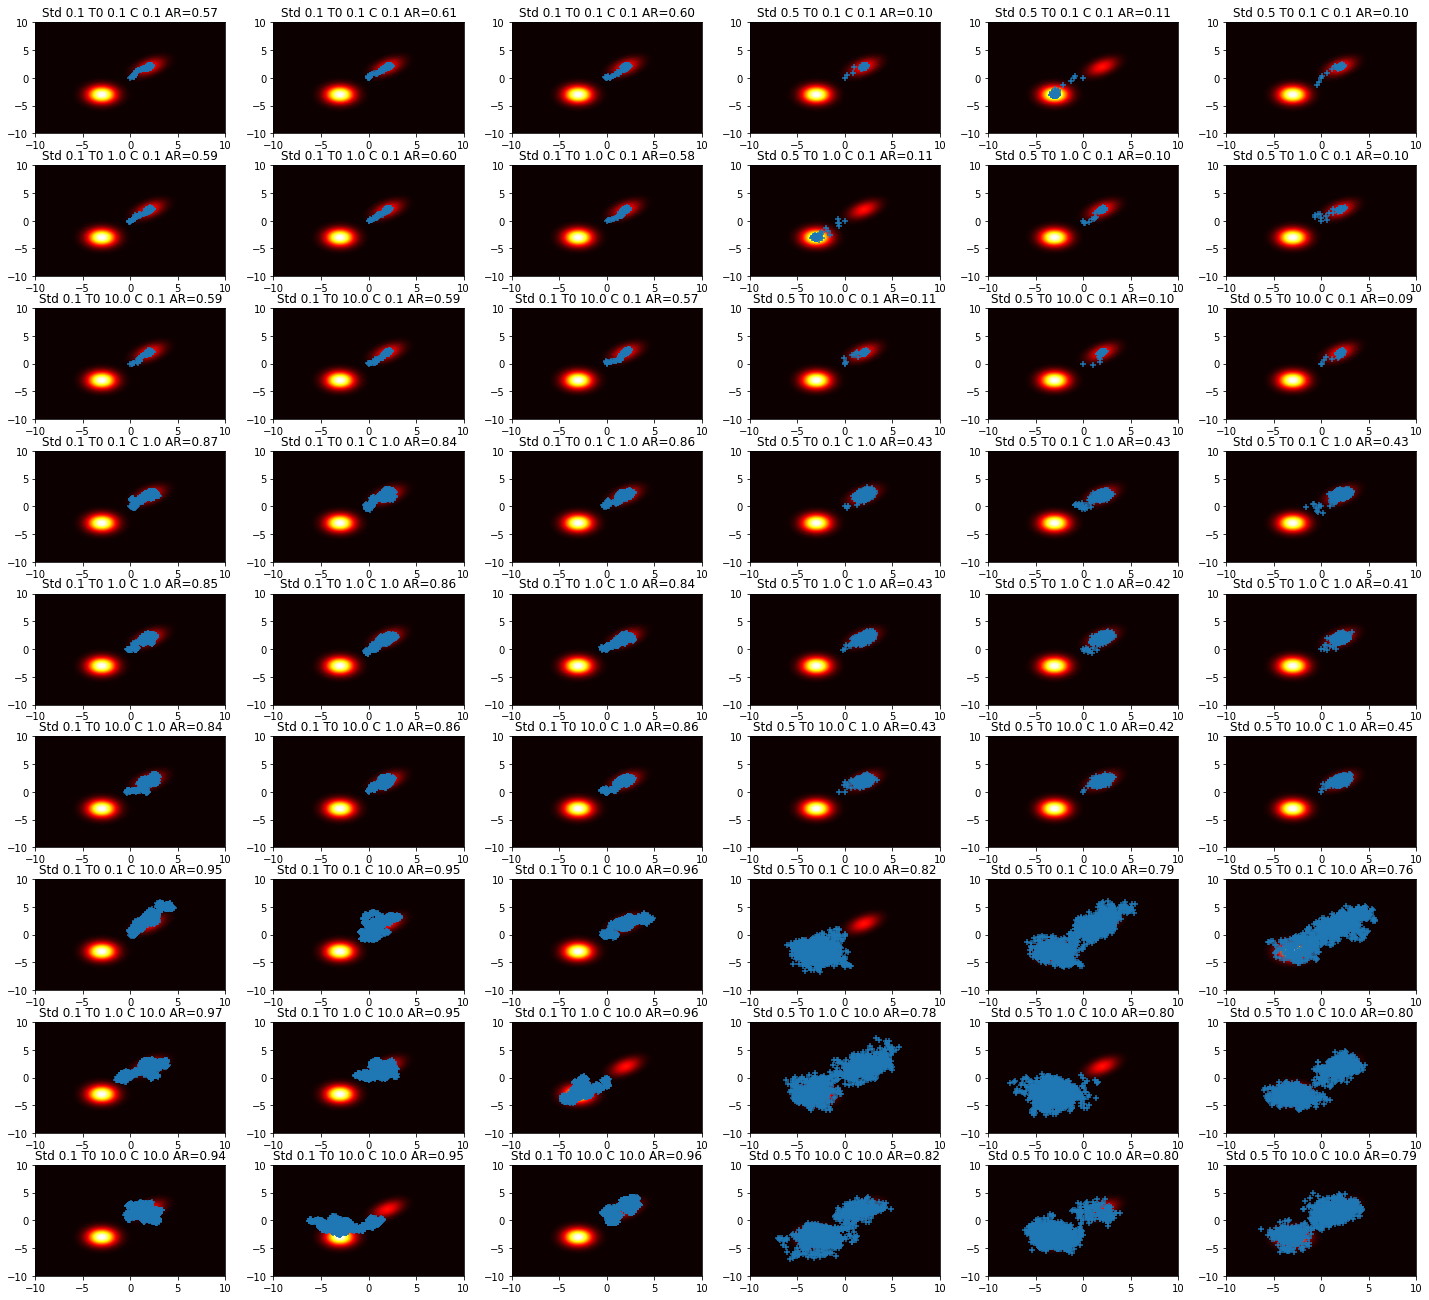

In [96]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500  # the number of epochs
stds_sa = [
    0.1,
    0.1,
    0.1,
    0.5,
    0.5,
    0.5,
]  # values of std; notice we repeat them due to randomness
T0s = [0.1, 1.0, 10.0]  # values of T0
Cs = [0.1, 1.0, 10.0]  # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s), len(stds_sa), figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0.0, 0.0]])

# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=prob, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(
                axs[len(T0s) * i + k, j],
                sampler=sa,
                title="Std " + str(sa.std) + " T0 " + str(T0) + " C " + str(C),
            )

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** PLEASE FILL IN

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** PLEASE FILL IN

**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** PLEASE FILL IN

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** PLEASE FILL IN

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** PLEASE FILL IN

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: PLEASE FILL IN

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: PLEASE FILL IN